In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# NOTE: change destination folder of dataset to suit.
sentiment140_data = pd.read_csv("datasets/training.1600000.processed.noemoticon.csv", 
                                encoding="ISO-8859-1", header=None, names=["target","id","date","flag","user","text"])

# Data Exploration

In [3]:
sentiment140_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
sentiment140_data.tail()

,target,id,date,flag,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [5]:
sentiment140_data.columns

Index(['target', 'id', 'date', 'flag', 'user', 'text'], dtype='object')

In [6]:
len(sentiment140_data)

1600000

In [7]:
sentiment140_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
np.sum(sentiment140_data.isnull().any(axis=1))

0

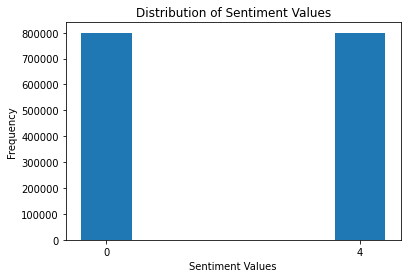

In [9]:
# Bar chart to check for data imbalance.
value_counts = sentiment140_data["target"].value_counts()
plt.bar(value_counts.index, value_counts.values)
plt.xlabel("Sentiment Values")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiment Values")
plt.xticks(value_counts.index)
plt.show()

# Data Preprocessing

## Drop columns that arent needed

In [10]:
data = sentiment140_data.drop(["id","date","flag","user"], axis=1)

In [11]:
data.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## Convert sentiment target values from integer to string

In [12]:
LABEL_MAP = {0:"Negative", 2:"Neutral", 4:"Positive"}
def label_decoder(label):
    return LABEL_MAP[label]

In [13]:
data.target = data.target.apply(lambda x: label_decoder(x))
data.head()

,target,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


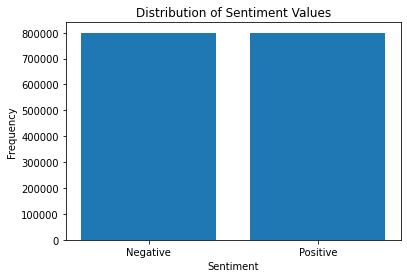

In [14]:
value_counts = data["target"].value_counts()
plt.bar(value_counts.index, value_counts.values)
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiment Values")
plt.xticks(value_counts.index)
plt.show()

## Data Cleaning

In [15]:
nltk.download('stopwords', quiet=True)

True

In [16]:
# TODO: handle emojis if time
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
TEXT_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [17]:
def preprocess(text, stem=False):
    text = re.sub(TEXT_RE, " ", str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [18]:
%%time
data["text"] = data["text"].apply(lambda x: preprocess(x))
data.head()

CPU times: total: 36.8 s
Wall time: 37 s


,target,text
0,Negative,awww bummer shoulda got david carr third day
1,Negative,upset update facebook texting might cry result...
2,Negative,dived many times ball managed save 50 rest go ...
3,Negative,whole body feels itchy like fire
4,Negative,behaving mad see


## Train Test Split

In [19]:
# TODO: remove X and Y later when/if not needed
X = data["text"]
y = data["target"]

TRAIN_SIZE = 0.7
train, test = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42)
X_train = train["text"]
X_test = test["text"]
y_train = train["target"]
y_test = test["target"]

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1119999,)
(480001,)
(1119999,)
(480001,)


In [21]:
X.head()

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2    dived many times ball managed save 50 rest go ...
3                     whole body feels itchy like fire
4                                     behaving mad see
Name: text, dtype: object

In [22]:
y.head()

0    Negative
1    Negative
2    Negative
3    Negative
4    Negative
Name: target, dtype: object

# Feature Extraction

## TF-IDF

In [23]:
NGRAM_RANGE = (1,2)
#MAX_FEATURES = 50000
tfidf = TfidfVectorizer(ngram_range=NGRAM_RANGE)

In [24]:
%%time
tfidf.fit(X_train)

CPU times: total: 19.3 s
Wall time: 19.3 s


TfidfVectorizer(ngram_range=(1, 2))

In [25]:
%%time
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

CPU times: total: 18.8 s
Wall time: 18.8 s


## Word Embedding

### Word Tokenization for Embedding

In [26]:
# NLTK tokenizer
from nltk.tokenize import RegexpTokenizer
regexp = RegexpTokenizer(r'\w+')
X_train_tk = X_train.apply(regexp.tokenize)
X_train_tk.head()

281802    [omg, bellllyyy, shoutin, sum, food, brb, sooo...
168792    [still, waiting, find, caca, stands, hoping, t...
911020                                               [face]
69604                          [sad, see, drive, away, wat]
979301            [dane, cook, isolated, incident, awesome]
Name: text, dtype: object

In [27]:
len(X_train_tk)

1119999

### Word2Vec

In [28]:
import gensim
from gensim.models import Word2Vec

In [29]:
%%time
VECTOR_SIZE = 300
EPOCHS = 16
word2Vec = gensim.models.Word2Vec(X_train_tk, min_count=5, vector_size=VECTOR_SIZE, window=5, workers=8, sg=1, epochs=EPOCHS, seed=42)

CPU times: total: 14min 21s
Wall time: 1min 55s


In [30]:
word2Vec.wv.most_similar('weather', topn=5)

[('sunny', 0.6054447889328003),
 ('rain', 0.5365291833877563),
 ('16c', 0.5361858606338501),
 ('wheater', 0.52989262342453),
 ('wheather', 0.5191665887832642)]

In [31]:
word2Vec.save("word2Vec.w2v")

In [32]:
#word2Vec = Word2Vec.load("word2Vec.w2v")

### Label Encoding

In [33]:
from sklearn.preprocessing import LabelEncoder

In [34]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train.tolist())
y_test_le = le.transform(y_test.tolist())

y_train_le = y_train_le.reshape(-1,1)
y_test_le = y_test_le.reshape(-1,1)

# Machine Learning Models

## Support Vector Machine

## Long Short-Term Memory Network

### Tokenization and Padding

In [35]:
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences

In [36]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

sequences = tokenizer.texts_to_sequences(X)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 335508
CPU times: total: 26.8 s
Wall time: 26.8 s


In [37]:
%%time
MAX_SEQUENCE_LENGTH = 100
X_train_tk = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_SEQUENCE_LENGTH)
X_test_tk = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_SEQUENCE_LENGTH)

print(X_train_tk.shape)
print(X_test_tk.shape)

(1119999, 100)
(480001, 100)
CPU times: total: 15.6 s
Wall time: 15.7 s


### Model

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [39]:
embedding_matrix = np.zeros((vocab_size, VECTOR_SIZE))
for word, i in tokenizer.word_index.items():
    if word in word2Vec.wv:
        embedding_matrix[i] = word2Vec.wv[word]
print(embedding_matrix.shape)

(335508, 300)


In [40]:
embedding_layer = Embedding(
    vocab_size, 
    VECTOR_SIZE, 
    weights=[embedding_matrix], 
    input_length=MAX_SEQUENCE_LENGTH, 
    trainable=False )

In [41]:
lstm = Sequential()
lstm.add(embedding_layer)
lstm.add(Dropout(0.5))
lstm.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
lstm.add(Dense(1))

lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          100652400 
                                                                 
 dropout (Dropout)           (None, 100, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 100,745,905
Trainable params: 93,505
Non-trainable params: 100,652,400
_________________________________________________________________


In [42]:
%%time
lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

CPU times: total: 46.9 ms
Wall time: 9.18 ms


In [44]:
# TODO: change epochs
history = lstm.fit(
    X_train_tk, y_train_le,
    batch_size=1024,
    epochs=8,
    validation_split=0.1,
    verbose=1,
    )

Epoch 1/8
985/985 [==============================] - 1133s 1s/step - loss: 0.6285 - accuracy: 0.6706 - val_loss: 0.5369 - val_accuracy: 0.7468
Epoch 2/8
985/985 [==============================] - 1096s 1s/step - loss: 0.5717 - accuracy: 0.7122 - val_loss: 0.5169 - val_accuracy: 0.7581
Epoch 3/8
985/985 [==============================] - 1106s 1s/step - loss: 0.5565 - accuracy: 0.7213 - val_loss: 0.5801 - val_accuracy: 0.7422
Epoch 4/8
985/985 [==============================] - 1107s 1s/step - loss: 0.5576 - accuracy: 0.7213 - val_loss: 0.5012 - val_accuracy: 0.7608
Epoch 5/8
985/985 [==============================] - 1116s 1s/step - loss: 0.5434 - accuracy: 0.7301 - val_loss: 0.5025 - val_accuracy: 0.7619
Epoch 6/8
985/985 [==============================] - 1113s 1s/step - loss: 0.5367 - accuracy: 0.7342 - val_loss: 0.4936 - val_accuracy: 0.7637
Epoch 7/8
985/985 [==============================] - 1091s 1s/step - loss: 0.5265 - accuracy: 0.7392 - val_loss: 0.4886 - val_accuracy: 0.7658

In [50]:
lstm.save("lstm.h5")

In [ ]:
#lstm = tf.keras.models.load_model('lstm.h5')

# Performance Evaluation Metrics

In [45]:
score = lstm.evaluate(X_test_tk, y_test_le, batch_size=1024)
print("ACCURACY:", score[1])

469/469 [==============================] - 74s 157ms/step - loss: 0.4922 - accuracy: 0.7654
ACCURACY: 0.7653671503067017


In [46]:
y_pred = lstm.predict(X_test_tk)

15001/15001 [==============================] - 249s 17ms/step


In [47]:
y_pred = np.where(y_pred>=0.5, 1, 0)

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test_le))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76    234339
           1       0.78      0.76      0.77    245662

    accuracy                           0.77    480001
   macro avg       0.77      0.77      0.77    480001
weighted avg       0.77      0.77      0.77    480001

